# Loading cloud-free Sentinel 2 and Landsat from multiple satellites into one dataset

**What does this notebook do?** 

This notebook demonstrates how to use the `load_clearlandsat` and `load_clearsentinel2` functions to import a time series of cloud-free observations from both multiple Landsat satellites (i.e. Landsat 5, 7 and 8) and Sentinel 2 (i.e. S2A and S2B) as a single combined xarray dataset, and then plot the data as a cloud-free time series animation with each frame annotated by satellite name.

**Requirements:**

You need to run the following commands from the command line prior to launching jupyter notebooks from the same terminal so that the required libraries and paths are set:

`module use /g/data/v10/public/modules/modulefiles` 

`module load dea`     (if this notebook results in **concatenation errors**, try again after loading in `module load dea/20180515`)

`module load ffmpeg`

This notebook uses three external functions called `load_clearlandsat`, `load_clearsentinel2` and `animated_timeseries`. These functions are available in the `10_Scripts` folder of the [dea-notebooks Github repository](https://github.com/GeoscienceAustralia/dea-notebooks/tree/master/10_Scripts). Note that these functions have been developed by DEA users, not the DEA development team, and so are provided without warranty. If you find an error or bug in the functions, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated function back into the repository (See the repository [README](https://github.com/GeoscienceAustralia/dea-notebooks/blob/master/README.rst) for instructions on creating a Pull request).

**Date:** September 2018

**Author:** Robbi Bishop-Taylor

### Import modules and functions

In [8]:
import os
import sys
import datacube
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datacube.utils import geometry
from datacube.utils.geometry import CRS
from datacube import Datacube

# Import external functions from dea-notebooks using relative link to Scripts
sys.path.append('../10_Scripts')
import DEAPlotting
import DEADataHandling

# Connect to datacube database
dc = datacube.Datacube(app='Time series animation')

def interpolate_timeseries(ds):

    # Shift time series up by one timestep and take average
    ds_shifted = ds.shift(time=1)
    ds_mean = (ds + ds_shifted) / 2.0

    # Shift time stamps up by one and take average, then sub into new ds
    time_int = ds_mean.time.astype('i8')
    time_shift_int = ds_mean.time.shift(time=1).astype('i8')
    time_shift_int[0] = time_int[0]
    time_ave = ((time_int + time_shift_int) / 2.0).astype('datetime64[ns]')
    ds_mean.coords['time'] = time_ave

    # Combine old and new datasets, skipping single timestep with no data
    ds_all = xr.auto_combine([ds, ds_mean]).sortby('time')
    ds_all = ds_all.isel(time=[0, *range(2, len(ds_all.time))])
    
    return ds_all

%load_ext autoreload
%autoreload 2


### Set up analysis variables
This sets the analysis extent, time period, output resolution and minimum proportion of cloud-free pixels used to filter the observations.

In [20]:
# Set up centre of area to analyse, and a buffer in metres around this centrepoint
lat, lon, buffer_m = -32.3451254903, 142.328819458, 8500

# Set range of time to return data from both Landsat and Sentinel 2
time_range = ('2015-06-01', '2017-01-01')

# Set the output resolution for both datasets. (-25, 25) will resample Sentinel 2 to the default Landsat 
# resolution of 25 m pixels, while higher values (e.g. (-100, 100)) can be useful for loading reduced 
# resolution data for large areas without exceeding memory limits
resolution = (-25, 25)

# Set up minimum proportions of cloud-free pixels required to return Landsat and Sentinel2 observations. 
# A proportion of 0.95 means that only observations with less than 5% cloud will be returned. Note that 
# the Sentinel 2 cloud mask is often more aggressive, and sometimes requires a lower threshold
landsat_clearprop, sentinel_clearprop = 0.99, 0.85

### Load in Landsat timeseries
Load in Landsat data for the centrepoint, buffer and time range specified above. This uses the `load_clearlandsat` function, which loads Landsat NBAR, NBART or FC25 for multiple sensors (i.e. ls5, ls7, ls8), and returns a single xarray dataset containing only observations that contain greater than a given proportion of clear pixels. This function was designed to extract visually appealing time series of observations that are not affected by cloud, for example as an input to the `animated_timeseries` function from `DEAPlotting`.
    
The proportion of clear pixels is calculated by summing the pixels that are flagged as being problematic in the Landsat PQ25 layer. By default only cloudy or cloud shadowed pixels or pixels without valid data in every band are included in the calculation, but this can be customised using the `mask_dict` function.

Loading ls5 pixel quality
    Skipping ls5; no valid data for query
Loading ls7 pixel quality
    Loading 0 filtered ls7 timesteps
Loading ls8 pixel quality
    Loading 13 filtered ls8 timesteps
Combining and sorting ls7, ls8 data
<xarray.Dataset>
Dimensions:    (time: 13, x: 625, y: 681)
Coordinates:
  * y          (y) float64 -3.556e+06 -3.556e+06 -3.556e+06 -3.556e+06 ...
  * x          (x) float64 9.554e+05 9.554e+05 9.554e+05 9.554e+05 9.555e+05 ...
  * time       (time) datetime64[ns] 2015-07-01T00:19:47 2015-09-19T00:20:21 ...
Data variables:
    red        (time, y, x) int16 1382 1150 1301 1176 1086 1141 1190 1156 ...
    green      (time, y, x) int16 821 710 766 734 714 729 746 739 747 714 ...
    blue       (time, y, x) int16 385 340 378 364 357 370 378 368 385 372 ...
    data_perc  (time) float64 1.0 0.9999 1.0 1.0 1.0 1.0 1.0 0.9994 0.9998 ...
    satellite  (time) object 'ls8' 'ls8' 'ls8' 'ls8' 'ls8' 'ls8' 'ls8' 'ls8' ...
Attributes:
    crs:      EPSG:3577


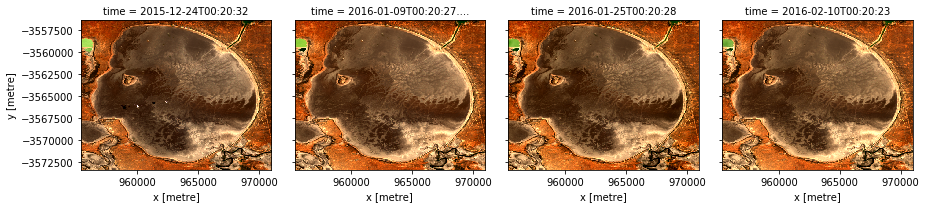

In [23]:
# Set up analysis data query using a buffer around a lat-long point (1280 x 720).
# This simply converts a lat long to Australian Albers, then creates a square analysis region
# by creating a square buffer around the point.
x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer_m + 700, x + buffer_m - 700),
         'y': (y - buffer_m, y + buffer_m),    
         'time': time_range,
         'crs': 'EPSG:3577',
         'output_crs': 'EPSG:3577',
         'resolution': resolution} 

# Load cloud free Landsat data for all sensors (LS5, LS7, LS8) for the above query. Setting 
# `satellite_metadata=True` will return the data with a variable that gives the abbreviation
# of the satellite that made the observation
landsat_ds = DEADataHandling.load_clearlandsat(dc=dc, query=query, sensors=['ls5', 'ls7', 'ls8'],
                                               bands_of_interest=['red', 'green', 'blue'],
                                               masked_prop=landsat_clearprop, 
                                               mask_pixel_quality=False,
                                               mask_invalid_data=False,
                                               satellite_metadata=True, 
                                               ls7_slc_off=True)

# Print and plot resulting data 
print(landsat_ds)
landsat_ds[['red', 'green', 'blue']].isel(time=range(3, 7)).to_array().plot.imshow(robust=True, col='time')

### Load in Sentinel 2 timeseries
This uses the `load_clearsentinel2` function to load Sentinel 2 data for multiple sensors (i.e. s2a, s2b) and returns a single xarray dataset containing only observations that contain greater than a given proportion of clear pixels. The proportion of clear pixels is calculated by summing the pixels that are flagged as being problematic in the Sentinel pixel quality array (also named `fmask`). By default pixels flagged as nodata, cloud or shadow are used to calculate the number of unclear pixels, but this can be customised using the `mask_values` function.

Before Sentinel 2 data can be combined with Landsat, the band names need to be renamed to match Landsat band names.

Loading s2a pixel quality
    Loading 8 filtered s2a timesteps
Loading s2b pixel quality
Skipping s2b; no valid data for query
Combining and sorting s2a data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
<xarray.Dataset>
Dimensions:    (time: 8, x: 625, y: 681)
Coordinates:
  * y          (y) float64 -3.556e+06 -3.556e+06 -3.556e+06 -3.556e+06 ...
  * x          (x) float64 9.554e+05 9.554e+05 9.554e+05 9.554e+05 9.555e+05 ...
  * time       (time) datetime64[ns] 2016-06-28T00:31:43.654000 ...
Data variables:
    red        (time, y, x) float64 1.586e+03 783.0 1.175e+03 1.275e+03 ...
    green      (time, y, x) float64 786.0 494.0 685.0 714.0 656.0 708.0 ...
    blue       (time, y, x) float64 403.0 246.0 338.0 352.0 363.0 341.0 ...
    data_perc  (time) float64 0.996 0.9962 0.9974 0.9987 0.9705 0.9788 ...
    satellite  (time) <U3 's2a' 's2a' 's2a' 's2a' 's2a' 's2a' 's2a' 's2a'
Attributes:
    crs:      EPSG:3577


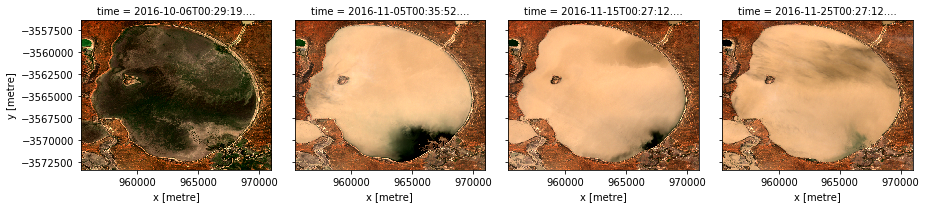

In [19]:
# Load cloud free Sentinel data for all sensors (S2A, S2B) for the above query. Setting 
# `satellite_metadata=True` will return the data with a variable that gives the abbreviation
# of the satellite that made the observation
sentinel_ds = DEADataHandling.load_clearsentinel2(dc=dc, query=query, sensors=['s2a', 's2b'],
                                                  bands_of_interest=['nbart_red', 'nbart_green', 'nbart_blue'],
                                                  masked_prop=sentinel_clearprop,
                                                  mask_pixel_quality=False,
                                                  mask_invalid_data=True,
                                                  pixel_quality_band='fmask',
                                                  satellite_metadata=True)

# Rename bands to match Landsat to allow combining/concatenating
sentinel_ds.rename({'nbart_red': 'red', 'nbart_green': 'green', 'nbart_blue': 'blue'}, inplace=True)

# Print and plot sample of resulting data 
print(sentinel_ds)
sentinel_ds[['red', 'green', 'blue']].isel(time=range(3, 7)).to_array().plot.imshow(robust=True, col='time')

### Combine Landsat and Sentinel 2 into a single dataset
Here we take both Landsat and Sentinel 2 datasets, and combine them into a single dataset. This dataset is sorted so that the data can be animated in time order, regardless of what satellites made the observations. The `satellite` variable gives the name of the satellite that made each observation.

In [ ]:
# Combine into one dataset
combined_ds = xr.auto_combine([landsat_ds, sentinel_ds])

# Sort by time
combined_ds = combined_ds.sortby('time')

# Print resulting data 
print(combined_ds)

## Animate output
To demonstrate how the resulting time series derived from different satellite sensors fit together seamlessly, we can produce an RGB animation using data from both Landsat and Sentinel 2:

In [ ]:
satellite_array = combined_ds.satellite
del combined_ds['satellite']

# Take rolling median
combined_ds = combined_ds.rolling(time=7, center=True, min_periods=1).median()
combined_ds['satellite'] = satellite_array

# Create a prettier list of satellite names for printing over the animation
pretty_names = {'ls5': 'Landsat 5', 'ls7': 'Landsat 7', 'ls8': 'Landsat 8', 
                's2a': 'Sentinel 2A', 's2b': 'Sentinel 2B'}
satellite_names = [pretty_names[i] for i in combined_ds.satellite.values]
satellite_names

# Produce an RGB animation that includes both Sentinel and Landsat observations, using
# the `title` parameter to print satellite names for each observation
DEAPlotting.animated_timeseries(ds=combined_ds,
                                output_path='combined_Landsat_Sentinel2.mp4', 
                                bands=['red', 'green', 'blue'], 
                                interval=130,
                                width_pixels=625,
                                title=satellite_names,
                                annotation_kwargs={'fontsize': 36},
                                percentile_stretch=[0.01, 0.99])